# Provided Code {-}

In [6]:
from collections import Counter
from random import shuffle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

%matplotlib inline

## Setup

In [2]:
def calculate_loop_edge_fraction(network, visited_nodes, boundary_nodes):
    """ Calculates the number of edges that go from the boundary to already visited nodes
    in addition to the number of edges that is expected if the network would be a tree.
    This number is then divided by the number of edges in total that go from the boundary
    to the visited nodes.

    In the case that the there are zero edges from the boundary to the visited nodes,
    this function returns zero (i.e., in the beginning when the boundary set is the same
    as the visited nodes).

    Parameters
    ----------
    network : networkx.Graph object
    visited_nodes : set object
      The set of nodes that are visited (including the boundary)
    boundary_nodes : set object
      The set of nodes that are in the boundary, i.e., the were visited in the last iteration.

    Returns
    -------
    The fraction described above : float

    """
    if len(visited_nodes) == 1:
        return 0

    edge_count = 0

    for node in boundary_nodes:
        for neighbor in network[node]:
            if neighbor in visited_nodes or neighbor in boundary_nodes:
                edge_count += 1

    if edge_count != 0:
        loop_count = edge_count -len(boundary_nodes)
        assert loop_count >= 0
        return loop_count/float(edge_count)
    else:
        return 0

In [3]:
def create_er_network(N, k_avg):
    """Creates a realisation of an Erdos-Renyi network.

    Parameters
    ----------
    N : int
       Number of nodes in the network.
    k_avg : float
       The value of edge probability p is set such that this is the
       expected average degree in the network.

    Returns
    -------

    net: a network object

    """
    p = k_avg / (N - 1) # Replace!
    return nx.fast_gnp_random_graph(N, p)

In [4]:
def get_largest_component_size(comp_dist):
    return max(comp_dist.keys())

In [5]:
def get_component_size_dist(net):
    """Calculates the (unnormalised) component size distribution of a network.

    For example, if the input network has 1 component of size 5 nodes and
    3 components of size 10 nodes, then this function will return a dictionary:
    {5:1, 10:3}.

    Parameters
    ----------
    net : networkx.Graph object

    Returns
    -------
    Dictionary (Counter, actually) where keys are component sizes and values are the number of
    components of that size.
    """
#     return Counter([len(comp) for comp in nx.connected_components(net)])
    return Counter( map(len, nx.connected_components(net)) )


In [22]:
def get_susceptibility(component_size_distribution):
    """Calculates the susceptibility (as defined in ex. 4.1e)

    Parameters
    ----------
    component_size_distribution : dict
       The component size distribution. See the function get_component_size_dist

    Returns
    -------
    Susceptibility value : float
    """
    
    s_max = max(component_size_distribution.keys())
    
    numerator = sum([s**2 * C_s for s, C_s in component_size_distribution.items()]) - s_max**2
    denominator = sum([s * C_s for s, C_s in component_size_distribution.items()]) - s_max
    if numerator < 0 or denominator < 0:
        print([s for s in component_size_distribution.values() if s < 0])
    
    return numerator / denominator

In [23]:
def ER_percolation(N, maxk, stepsize=0.1):
    """Builds ER networks with average degrees from 0 to maxk and
       plots the size of the largest connected component and susceptibility
       as a function of the average degree.

    Parameters
    ----------
    N : int
      Number of nodes in the ER network
    maxk : float
      The maximum average degree
    stepsize : float
      The size of the step after which the LCC and susceptibility is calculated.
      I.e., they are plotted at 0, stepsize, 2*stepsize, ..., maxk

    Returns
    -------
    fig : figure handle
    """

    klist = np.arange(0.0, maxk, stepsize)
    giantsize = []
    smallsize = []

    # Loop over the avg degree range
    for k in klist:
        print("Doing the calculations for avg degree:")
        print(k)

        # Generate an ER network with N nodes and avg degree k
        net = create_er_network(N, k)

        # Get the distribution of component sizes
        component_size_dist = get_component_size_dist(net)

        # Galculate the largest component size
        giantsize.append(get_largest_component_size(component_size_dist))

        # Calculate the avg component size for the other components
        susceptibility = get_susceptibility(component_size_dist)
        smallsize.append(susceptibility)
        if susceptibility < 0:
            print(susceptibility, component_size_dist)

    # plot the numbers
    plt.rc('text', usetex=True)
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)

    ax.plot(klist, giantsize, 'r-')
    ax.set_xlabel('Average k') # TODO: label the axis!
    ax.set_ylabel('Giant Size') # TODO: label the axis!

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(klist, smallsize, 'k-')
    # YOUR CODE HERE
    ax2.set_xlabel('Average k')  # TODO: label the axis!
    ax2.set_ylabel(r"$\chi$ Size")  # TODO: label the axis!

    fig.suptitle('Number of nodes = ' + str(N))
    # plt.show() # uncomment if you want to display the figure on the screen

    return fig

In [24]:
def expand_breadth_first_search(network, visited_nodes, boundary_nodes):
    """Performs one step in a breadth first search and updates the visited nodes
    and boundary nodes sets that are given as parameters accordingly. Here one
    step means that we will find all nodes that are one step further away from
    the starting node. These nodes will form the new boundary.

    Parameters
    ----------
    network : networkx.Graph object
    visited_nodes : set object
      The set of nodes that are visited (including the boundary)
    boundary_nodes : set object
      The set of nodes that are in the boundary, i.e., the were visited in the last iteration.

    Returns
    -------
    Nothing, the visited nodes an boundary nodes are update in place.

    """

    new_boundary = set()
    new_boundary.update(*[list(network.neighbors(node)) for node in boundary_nodes])
    
    visited_nodes |= new_boundary

    boundary_nodes.clear()
    boundary_nodes.update(new_boundary)

    # We return nothing as the results were updated to visited_nodes and boundary_nodes


def ER_breadth_first_search(avg_degree, net_size, number_of_samples,
                            max_depth=15, show_netsize=False):
    """Creates a figure of breadth first search in an ER network.

    Parameters
    ----------
    avg_degree : float
      The expected degree of the nodes in the ER network
    net_size : int
      The number of nodes in the ER network
    number_of_samples : int
       The number of randomly selected starting node for the BFS
    max_depth : int
       The maximum depth of the BFS
    show_netsize : bool
       If True, we will plot the size of the network in the first panel as a dotter horizontal line.

    Returns
    -------
    fig : figure object
    """
    net = create_er_network(net_size, avg_degree)

    # We will count the number of nodes and the loop fraction for each depth and each
    # starting node. That is, we need a 2-dimensional list to save these results.
    # The element node_count[depth][sample_number] gives the number of nodes at the boundary
    # of the BFS at the given depth for given sample number.
    # The code below will create lists of length max_depth where each element is an empty list.
    node_count = [[] for depth in range(max_depth+1)]
    loop_edge_fraction = [[] for depth in range(max_depth+1)]

    # Next we will run the BFS until max_depth for each randomly selected sample
    for _ in range(number_of_samples):
        # Choose random starting node:
        start_node = random.randint(0, net_size-1)
        # In the beginning we have only visited the start node:
        visited_nodes = {start_node}
        # The start node is also the only boundary node, see expand_breadth_first_search:
        boundary_nodes = {start_node}

        for depth in range(max_depth+1):
            number_of_boundary_nodes = len(boundary_nodes)

            fraction_of_loop_edges = calculate_loop_edge_fraction(net,
                                                                  visited_nodes, boundary_nodes)
            
            # Update the visited nodes and the boundary
            expand_breadth_first_search(net, visited_nodes, boundary_nodes)

            # Saving the results
            node_count[depth].append(number_of_boundary_nodes)
            loop_edge_fraction[depth].append(fraction_of_loop_edges)

    # Averaging over the different starting nodes.
    avg_node_count = list(map(np.mean, node_count))
    avg_loop_edge_fraction = list(map(np.mean, loop_edge_fraction))

    # Calculating the theoretical values, assuming the network is a tree
    avg_node_count_theoretical = [avg_degree**depth for depth in range(max_depth + 1)]
    
    #Plotting the results
    fig = plt.figure(figsize=(4, 8))
    ax1 = fig.add_subplot(211)

    ax1.semilogy(list(range(max_depth+1)), avg_node_count, "x", label="Simulation")
    ax1.semilogy(list(range(max_depth+1)), avg_node_count_theoretical, label="Theoretical")

    if show_netsize:
        ax1.semilogy([0, max_depth], 2*[net_size], "k--")

    # YOUR CODE HERE
    ax1.set_xlabel("Depth") # Set proper axis labels!
    ax1.set_ylabel("Average Node Count") # Set proper axis labels!
    ax1.set_xlim(0, max_depth)
    ax1.set_title("Average Degree: {}, Network Size: {}".format(avg_degree, net_size))
    ax1.legend()


    ax2 = fig.add_subplot(212)
    ax2.plot(list(range(max_depth+1)), avg_loop_edge_fraction, "x", label="Simulation")
    # YOUR CODE HERE
    ax2.set_xlabel("Depth") # Set proper axis labels!
    ax2.set_ylabel("Average Loop Edge Fraction") # Set proper axis labels!
    ax2.set_xlim(0, max_depth)
    ax2.set_ylim(0, 1)
    ax2.set_title("Average Degree: {}, Network Size: {}".format(avg_degree, net_size))

#     plt.show() # uncomment if you want to display the figure on the screen

    return fig


## Main

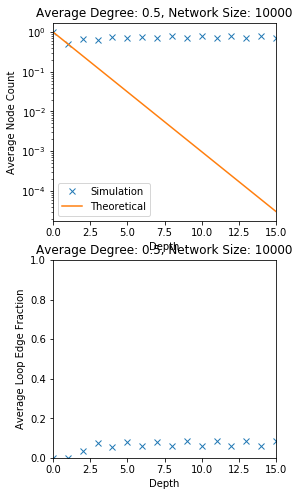

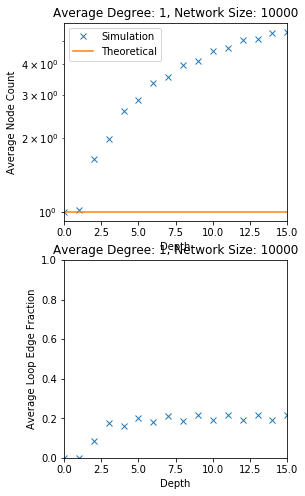

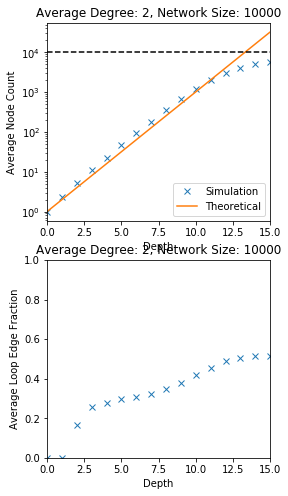

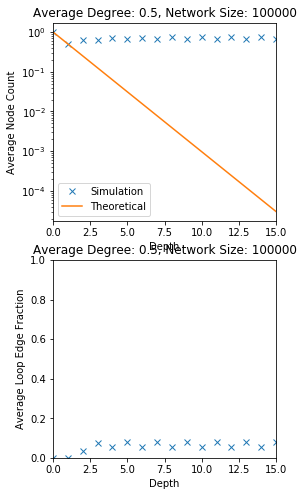

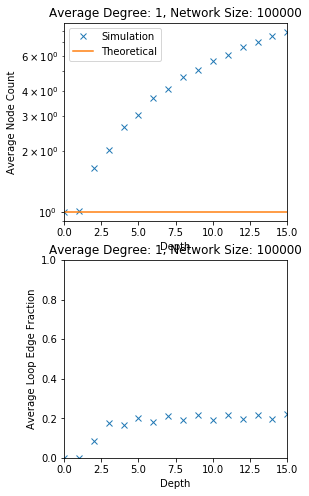

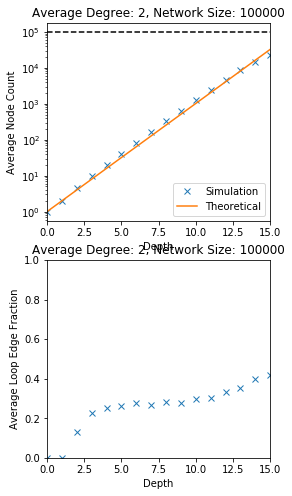

In [30]:
fig = ER_breadth_first_search(0.5, 10**4, 10000)
fig.savefig('./er_breadthfirst_05_10k.png')

fig = ER_breadth_first_search(1, 10**4, 10000)
fig.savefig('./er_breadthfirst_1_10k.png')

fig = ER_breadth_first_search(2, 10**4, 100, show_netsize=True, max_depth=15)
fig.savefig('./er_breadthfirst_2_10k.png')

fig = ER_breadth_first_search(0.5, 10**5, 10000)
fig.savefig('./er_breadthfirst_05_100k.png')

fig = ER_breadth_first_search(1, 10**5, 10000)
fig.savefig('./er_breadthfirst_1_100k.png')

fig = ER_breadth_first_search(2, 10**5, 100, show_netsize=True, max_depth=15)
fig.savefig('./er_breadthfirst_2_100k.png')



## 1c Written

- **Number of samples**. Increasing this number would usually get us closer to our theoretical values
- **Number of nodes**. We're not dealing with an infinite number of nodes, we're just dealing with a lot of nodes to approximate properties at infinity. This approximation propagates to our actual values, making them deviate from the theoretical ones.

Doing the calculations for avg degree:
0.0
Doing the calculations for avg degree:
0.05
Doing the calculations for avg degree:
0.1
Doing the calculations for avg degree:
0.15000000000000002
Doing the calculations for avg degree:
0.2
Doing the calculations for avg degree:
0.25
Doing the calculations for avg degree:
0.30000000000000004
Doing the calculations for avg degree:
0.35000000000000003
Doing the calculations for avg degree:
0.4
Doing the calculations for avg degree:
0.45
Doing the calculations for avg degree:
0.5
Doing the calculations for avg degree:
0.55
Doing the calculations for avg degree:
0.6000000000000001
Doing the calculations for avg degree:
0.65
Doing the calculations for avg degree:
0.7000000000000001
Doing the calculations for avg degree:
0.75
Doing the calculations for avg degree:
0.8
Doing the calculations for avg degree:
0.8500000000000001
Doing the calculations for avg degree:
0.9
Doing the calculations for avg degree:
0.9500000000000001
Doing the calculations for

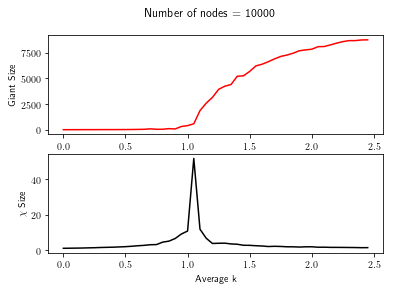

In [25]:
#Solution for d)-e):
fig = ER_percolation(10**4, 2.5, 0.05)
fig.savefig('./er_percolation.png')

# Question 2

In [4]:
def get_giant_size(net):
    """
    Calculates the size of the largest component (i.e. the giant component) of
    the network.

    Parameters
    ----------
    net: networkx.Graph() object

    Returns
    -------
    giant_size: int
        size of the giant component

    """
    return max( map(len, nx.connected_components(net)) )

def simulate_edge_removal(orignet, order):
    """
    Performs an edge removal simulation

    Parameters
    ----------
    orignet: networkx.Graph() object
        Network in which the edge removal is simulated. A copy of orignet is
        created for the simulations, and the original network is not changed.
    order: list of tuples
        network edges sorted in the order in which they will be removed

    Returns
    -------
    giant_sizes: np.array of ints
        sizes of the giant component at different edge densities
    """
    giant_sizes = []
    net = orignet.copy() # Creating a copy of the original network
    
    next_print_frac = 0.1
    for idx, edge in enumerate(order):
        net.remove_edge(*edge)
        giant_sizes.append(get_giant_size(net))
        
        if idx/len(order) > next_print_frac:
            print("  {}% completed".format( round(next_print_frac * 100) ))
            next_print_frac += 0.1
    return giant_sizes

def get_net_and_betweenness(path):
    net = nx.read_weighted_edgelist(path) # Read the network from path
    print("Computing betweenness...")
    betweenness = nx.edge_betweenness_centrality(net)
    
    return (net, betweenness)
    

def run_link_removal(net, betweenness, net_name):
    """
    Sets up framework and runs the edge removal simulation.

    Parameters
    ----------
    path: string
        path to the network to be analyzed
    net_name: string
        name of the network (for labeling)

    Returns
    -------
    No direct output, saves figure of the giant component size as a function
    of network density.
    """
    # setting up:
    # YOUR CODE HERE
    N = len(net.nodes()) # Replace with the number of nodes
    edges = list(net.edges()) # Replace with the network edges

    fig = plt.figure(figsize=(16, 16 * 3 / 4.))
    ax = fig.add_subplot(111)
    fig.suptitle(net_name)

    def edge_to_weight(edge): 
        return net.get_edge_data(*edge)['weight']
    
    ascending_weight_edge_order = sorted(edges, key=edge_to_weight) 
    descending_weight_edge_order = ascending_weight_edge_order[::-1]
    
    random_edge_order = edges.copy()
    shuffle(random_edge_order)

    def edge_to_betweenness(edge): 
        return betweenness[edge]
    
    # sorting the edges by their betweenness:
    ebc_edge_order = sorted(edges, key=edge_to_betweenness, reverse=True)
    
    # edge removal:
    for order, order_name, color, ls, lw in zip(
        [descending_weight_edge_order, ascending_weight_edge_order,
         random_edge_order, ebc_edge_order],
        ["w_big_first",
         "w_small_first", 'random', "betweenness"],
        ["r", "y", "b", "k"],
        ["-", "-", "-", "-"],
        [2, 3, 4, 5]
    ):
        print(order_name.upper())

        giant_sizes = simulate_edge_removal(net, order)
        fracs = np.linspace(0, 1, len(giant_sizes))

        ax.plot(fracs, np.array(giant_sizes) / float(N), "-", color=color, ls=ls,
                label="g " + order_name, lw=lw)

        ax.set_ylabel('Largest Component Size (relative to network size)') 
        ax.set_xlabel('Fraction of Removed Links')

        ax.legend(loc=2)

    return fig



## Main

In [5]:


network_path = './OClinks_w_undir.edg' # You may want to change the path to the edge list file
network_name = 'fb-like-network'

net, betweenness = get_net_and_betweenness(network_path)

NameError: name 'nx' is not defined

In [3]:

fig = run_link_removal(net, betweenness, network_name)
fig.savefig("./fb_like_error_and_attack_tolerance.png")

NameError: name 'net' is not defined

Computing betweenness...


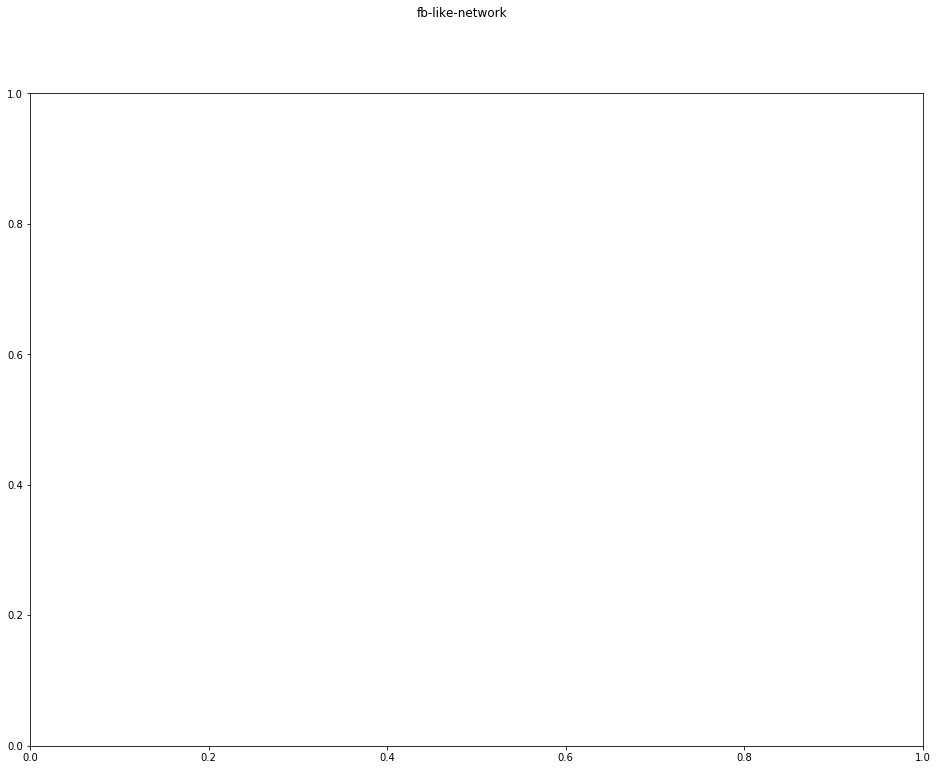

In [7]:
network_path = './OClinks_w_undir.edg' # You may want to change the path to the edge list file
net_name = 'fb-like-network'

net, betweenness = get_net_and_betweenness(network_path)


"""
Sets up framework and runs the edge removal simulation.

Parameters
----------
path: string
    path to the network to be analyzed
net_name: string
    name of the network (for labeling)

Returns
-------
No direct output, saves figure of the giant component size as a function
of network density.
"""
# setting up:
# YOUR CODE HERE
N = len(net.nodes()) # Replace with the number of nodes
edges = list(net.edges()) # Replace with the network edges

fig = plt.figure(figsize=(16, 16 * 3 / 4.))
ax = fig.add_subplot(111)
fig.suptitle(net_name)

def edge_to_weight(edge): 
    return net.get_edge_data(*edge)['weight']

ascending_weight_edge_order = sorted(edges, key=edge_to_weight) 
descending_weight_edge_order = ascending_weight_edge_order[::-1]

random_edge_order = edges.copy()
shuffle(random_edge_order)

def edge_to_betweenness(edge): 
    return betweenness[edge]

# sorting the edges by their betweenness:
ebc_edge_order = sorted(edges, key=edge_to_betweenness, reverse=True)

In [8]:
# edge removal:
for order, order_name, color, ls, lw in zip(
    [descending_weight_edge_order, ascending_weight_edge_order,
     random_edge_order, ebc_edge_order],
    ["w_big_first",
     "w_small_first", 'random', "betweenness"],
    ["r", "y", "b", "k"],
    ["-", "-", "-", "-"],
    [2, 3, 4, 5]
):
    print(order_name.upper())

    giant_sizes = simulate_edge_removal(net, order)
    fracs = np.linspace(0, 1, len(giant_sizes))

    ax.plot(fracs, np.array(giant_sizes) / float(N), "-", color=color, ls=ls,
            label="g " + order_name, lw=lw)

    ax.set_ylabel('Largest Component Size (relative to network size)') 
    ax.set_xlabel('Fraction of Removed Links')

    ax.legend(loc=2)

W_BIG_FIRST
  10% completed
  20% completed
  30% completed
  40% completed
  50% completed
  60% completed
  70% completed
  80% completed
  90% completed
W_SMALL_FIRST
  10% completed
  20% completed
  30% completed
  40% completed
  50% completed
  60% completed
  70% completed
  80% completed
  90% completed
RANDOM
  10% completed
  20% completed
  30% completed
  40% completed
  50% completed
  60% completed
  70% completed
  80% completed
  90% completed
BETWEENNESS
  10% completed
  20% completed
  30% completed
  40% completed
  50% completed
  60% completed
  70% completed
  80% completed
  90% completed


In [10]:
np.array(giant_sizes)

array([1890, 1890, 1890, ...,    2,    2,    1])